# CAO Points Notebook

***

Import all the necessary packages

In [1]:
# Package for HTTP requests
import requests as rq

# Regular experssions package
import re

# Import Pandas package
import pandas as pd

# Dates and time
import datetime as dt

# For comparing sequences (string for example)
import difflib

# For downloading files form the web
import urllib.request as urlrq

# For scatter plots
from pandas.plotting import scatter_matrix

#### Create a now_string

This variable will be used to store the current date and time and used when saving the original data files with a timestamp

In [2]:
# get the current date and time
now = dt.datetime.now()

now_string = now.strftime('%Y%m%d_%H%M%S')

## 1. Read and prepare the 2019 points

****

### 1.1 Read the 2019 points


1. Points for 2019 year downloaded from http://www.cao.ie/index.php?page=points&p=2019 in .pdf file format
2. PDF file opened using Adobe Acrobat DC
3. Exported to .xlsx file format using Acrobat DC 'Export to' option
4. Pandas DataFrame created from saved .xlsx file

In [3]:
df19 = pd.read_excel('data\cao2019_20211129_180145.xlsx', skiprows=10, dtype=str)

In [4]:
#Check the head of the dataframe
df19.head()

,Course Code,Unnamed: 1,INSTITUTION and COURSE,Unnamed: 3,EOS,Mid
0,NaN,NaN,Athlone Institute of Technology,NaN,NaN,NaN
1,AL801,NaN,Software Design with Virtual Reality and Gaming,NaN,304,328
2,AL802,NaN,Software Design with Cloud Computing,NaN,301,306
3,AL803,NaN,Software Design with Mobile Apps and Connected...,NaN,309,337
4,AL805,NaN,Network Management and Cloud Infrastructure,NaN,329,442


### 1.2 Clean the data

In [5]:
# List columns in imported dataframe
df19.columns

Index(['Course Code', 'Unnamed: 1', 'INSTITUTION and COURSE', 'Unnamed: 3',
       'EOS', 'Mid'],
      dtype='object')

In [6]:
# Drop the columns that hold no data.
df19 = df19.drop(['Unnamed: 1', 'Unnamed: 3'], axis=1)

In [7]:
#Check the head of the dataframe after removing Unnamed columns:
df19.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid
0,NaN,Athlone Institute of Technology,NaN,NaN
1,AL801,Software Design with Virtual Reality and Gaming,304,328
2,AL802,Software Design with Cloud Computing,301,306
3,AL803,Software Design with Mobile Apps and Connected...,309,337
4,AL805,Network Management and Cloud Infrastructure,329,442


In [8]:
#Check the tail of the dataframe to make sure all the courses were imported:
df19.tail()

,Course Code,INSTITUTION and COURSE,EOS,Mid
960,WD200,Arts (options),221,296
961,WD210,Software Systems Development,271,329
962,WD211,Creative Computing,275,322
963,WD212,Recreation and Sport Management,274,311
964,WD230,Mechanical and Manufacturing Engineering,273,348


#### Create a list of HEI from 2019 dataset

In [9]:
# As the HEI list from 2020 data is not complete, I will create a list of HEI from 2019 data points
# 2019 dataset has a row with HEI description at the top of the list of courses in this institute
# I'll create a 'Code' column by coping the value of 'Course Code' from the next row
# As per https://stackoverflow.com/questions/30673209/pandas-compare-next-row

df19['Code'] = df19['Course Code'].shift(-1)
df19

,Course Code,INSTITUTION and COURSE,EOS,Mid,Code
0,NaN,Athlone Institute of Technology,NaN,NaN,AL801
1,AL801,Software Design with Virtual Reality and Gaming,304,328,AL802
2,AL802,Software Design with Cloud Computing,301,306,AL803
3,AL803,Software Design with Mobile Apps and Connected...,309,337,AL805
4,AL805,Network Management and Cloud Infrastructure,329,442,AL810
...,...,...,...,...,...
960,WD200,Arts (options),221,296,WD210
961,WD210,Software Systems Development,271,329,WD211
962,WD211,Creative Computing,275,322,WD212
963,WD212,Recreation and Sport Management,274,311,WD230


In [10]:
# Keep only two first letters in the 'Code' column
df19['Code'] = df19['Code'].str[0:2]
df19.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid,Code
0,NaN,Athlone Institute of Technology,NaN,NaN,AL
1,AL801,Software Design with Virtual Reality and Gaming,304,328,AL
2,AL802,Software Design with Cloud Computing,301,306,AL
3,AL803,Software Design with Mobile Apps and Connected...,309,337,AL
4,AL805,Network Management and Cloud Infrastructure,329,442,AL


In [11]:
#institute names are stored in the rows that don't have any values in the 'Course code' column
hei19 = df19[df19['Course Code'].isna()][['INSTITUTION and COURSE', 'Code']]
hei19.columns=['HEI', 'Code']
hei19.head()

,HEI,Code
0,Athlone Institute of Technology,AL
28,"Institute of Technology, Carlow",CW
62,"Carlow College, St. Patrick`s",PC
66,Cork Institute of Technology,CR
110,University College Cork (NUI),CK


In [12]:
# Column 'Code' is not needed anymore in the df19 table, removing it
df19 = df19.drop('Code',  axis=1)

In [13]:
#Remove the rows with HEI description:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
print("Shape of the dataFrame with HEI names: {}".format(df19.shape))
df19 = df19.dropna(axis=0, subset=['Course Code'])
print("Shape of the dataFrame without HEI names: {}".format(df19.shape))

Shape of the dataFrame with HEI names: (965, 4)
Shape of the dataFrame without HEI names: (930, 4)


In [14]:
# Check that all the rows without values defined in 'Course Code' column are removed
df19[df19['Course Code'].isna()]

,Course Code,INSTITUTION and COURSE,EOS,Mid


### 1.3 Format the data 

In [15]:
# 1. Filter df19 dataframe to include only EOS points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

df19['2019 Interview'] = 0

for index, row in df19[df19['EOS'].str.startswith('#', na=False)].iterrows():
    points = df19.loc[index, 'EOS'][1:]
    
    df19.loc[index, 'EOS'] = points
    df19.loc[index, '2019 Interview'] = 1

In [16]:
# Check that a new column 'Test/Interview #' was created and populated correctly and that # was removed from the points value
df19[df19['2019 Interview']==1].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,2019 Interview
24,AL861,Animation and Illustration (portfolio),615,899,1
25,AL863,Graphic and Digital Design (portfolio),703,898,1
31,CW038,"Art (portfolio, Wexford)",700,700,1
58,CW858,"Sports Management and Coaching (options, portf...",700,700,1
74,CR121,Music at CIT Cork School of Music,633,1052,1


In [17]:
# Display 5 top courses that have '*' at the end of the points 
df19[df19['EOS'].str.endswith('*', na=False)].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,2019 Interview
129,CK201,Commerce,465*,489,0
163,CK704,Occupational Therapy,532*,554,0
166,CK707,Medical and Health Sciences,510*,543,0
172,CK791,Medicine - Graduate Entry (GAMSAT required),58*,59,1
179,CM001,Education - Primary Teaching,452*,462,0


In [18]:
# 1. Filter df19 dataframe to include only EOS points that have '*' at the end
# 2. Once it's filtered, iterate through it to remove the '*' from the poitns value
# 3. Add the '*' to the 'R1 Random *' column

df19['2019 R1 Random'] = 0

for index, row in df19[df19['EOS'].str.endswith('*', na=False)].iterrows():
    points = df19.loc[index, 'EOS'][:-1]
    
    df19.loc[index, 'EOS'] = points
    df19.loc[index, '2019 R1 Random'] = 1

In [19]:
# Check that a new column 'R1 Random *' was created and populated correctly and that * was removed from the points value
df19[df19['2019 R1 Random']==1].head(5)

,Course Code,INSTITUTION and COURSE,EOS,Mid,2019 Interview,2019 R1 Random
129,CK201,Commerce,465,489,0,1
163,CK704,Occupational Therapy,532,554,0,1
166,CK707,Medical and Health Sciences,510,543,0,1
172,CK791,Medicine - Graduate Entry (GAMSAT required),58,59,1,1
179,CM001,Education - Primary Teaching,452,462,0,1


In [20]:
# Display 5 top courses that have '*' at the end of the 'Mid' column values
df19[df19['Mid'].str.endswith('*', na=False)]

,Course Code,INSTITUTION and COURSE,EOS,Mid,2019 Interview,2019 R1 Random


#### Rename the column to match the general template

In [21]:
# Rename the columns in the df19 dataFrame
df19.columns=['COURSE CODE','COURSE TITLE', 'R1 2019', 'R2 2019', '2019 Interview', '2019 R1 Random']
df19.head()

,COURSE CODE,COURSE TITLE,R1 2019,R2 2019,2019 Interview,2019 R1 Random
1,AL801,Software Design with Virtual Reality and Gaming,304,328,0,0
2,AL802,Software Design with Cloud Computing,301,306,0,0
3,AL803,Software Design with Mobile Apps and Connected...,309,337,0,0
4,AL805,Network Management and Cloud Infrastructure,329,442,0,0
5,AL810,Quantity Surveying,307,349,0,0


In [22]:
# Set the 'COURSE CODE' column as an Index
df19.set_index('COURSE CODE', inplace=True)
df19.head()

,COURSE TITLE,R1 2019,R2 2019,2019 Interview,2019 R1 Random
COURSE CODE,,,,,
AL801,Software Design with Virtual Reality and Gaming,304,328,0,0
AL802,Software Design with Cloud Computing,301,306,0,0
AL803,Software Design with Mobile Apps and Connected...,309,337,0,0
AL805,Network Management and Cloud Infrastructure,329,442,0,0
AL810,Quantity Surveying,307,349,0,0


In [23]:
# Currently columns 'R1 2019' and 'R2 2019' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df19['R1 2019'] = pd.to_numeric(df19['R1 2019'], errors='coerce')
df19['R2 2019'] = pd.to_numeric(df19['R2 2019'], errors='coerce')

In [24]:
df19.head()

,COURSE TITLE,R1 2019,R2 2019,2019 Interview,2019 R1 Random
COURSE CODE,,,,,
AL801,Software Design with Virtual Reality and Gaming,304.0,328.0,0,0
AL802,Software Design with Cloud Computing,301.0,306.0,0,0
AL803,Software Design with Mobile Apps and Connected...,309.0,337.0,0,0
AL805,Network Management and Cloud Infrastructure,329.0,442.0,0,0
AL810,Quantity Surveying,307.0,349.0,0,0


#### Export the DataFrame to csv file

In [25]:
# Create a filepath with a current timestamp for the pandas data
filepath = 'data/cao2019_pandas' + now_string + '.csv'

# save the pandas dataframe as a csv file
df19.to_csv(filepath, index=False)

## 2. Read and prepare the 2020 points
****

### 2.1 Read the 2020 points from the CAO website

In [26]:
# Read the file directly from the CAO website
url = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'
df20 = pd.read_excel(url, skiprows=10)

##### Download the original 2020 file to the disk

In [27]:
# Create a filepath with a current timestamp for the original data
filepath = 'data/cao2020_' + now_string + '.xlsx'

In [28]:
urlrq.urlretrieve(url, filepath)

('data/cao2020_20211215_200935.xlsx',
 <http.client.HTTPMessage at 0x1b208a39460>)

In [29]:
# Check the shape of the dataframe
df20.shape

(1464, 23)

### 2.2 Clean the data

In [30]:
# Show 5 first rows of the dataframe
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns named Column1-Column8 serve no purpose, they need to be removed. First I will list all the columns in the dataframe and then use it as a reference for removing them:

In [31]:
# List the columns in the datafarme
df20.columns

Index(['CATEGORY (i.e.ISCED description)', 'COURSE TITLE', 'COURSE CODE2',
       'R1 POINTS', 'R1 Random *', 'R2 POINTS', 'R2 Random*', 'EOS',
       'EOS Random *', 'EOS Mid-point', 'LEVEL', 'HEI', 'Test/Interview #',
       'avp', 'v', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8'],
      dtype='object')

In [32]:
# There are 23 columns in the dataframe, we need to remove 8, so we'll remove the columns from 15 to 23:
df20 = df20.drop(df20.columns[15:23], axis=1)

In [33]:
# Check the head of the dataframe to make sure correct columns were removed
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,8,American College,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,8,American College,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN


In [34]:
# Check the end of the dataframe, to make sure all the rows were loaded
df20.tail()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,7,Waterford Institute of Technology,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,8,Waterford Institute of Technology,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,8,Waterford Institute of Technology,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,8,Waterford Institute of Technology,NaN,NaN,NaN
1463,Engineering and engineering trades,Mechanical and Manufacturing Engineering,WD230,253,NaN,NaN,NaN,253,NaN,369,8,Waterford Institute of Technology,NaN,NaN,NaN


In [35]:
# Spot check, make sure that Excels row 765 was imported correctly. 
# Recalculate the index by substracting 10 skipped rows and allow for the fact that panda numbers rows from 0 and Excel from 1 plus allow for the first row being used as header
df20.iloc[765-12]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Road Transport Technology and Management
COURSE CODE2                                                           LC286
R1 POINTS                                                                264
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      264
EOS Random *                                                             NaN
EOS Mid-point                                                            360
LEVEL                                                                      7
HEI                                         Limerick Institute of Technology
Test/Interview #                                                         NaN

### 2.3 Format the data

In [36]:
# 1. Filter df20 dataframe to include only EOS points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

for index, row in df20[df20['R1 POINTS'].str.startswith('#', na=False)].iterrows():
    points = df20.loc[index, 'R1 POINTS'][1:]
    
    df20.loc[index, 'R1 POINTS'] = points

df20.head(5)

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,8,American College,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,8,American College,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,8,National College of Art and Design,#,NaN,NaN


In [37]:
# Some of the rows that
df20 = df20.replace('#',1)

In [38]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
df20 = df20.replace('*',1)

In [39]:
df20[df20['R1 Random *']==1].head(5)

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
53,Health,Psychiatric Nursing,AL832,387,1.0,384,NaN,384,NaN,399,8,Athlone Institute of Technology,NaN,NaN,NaN
74,Education,"Education, Home Economics and Religious Ed - w...",AS002,441,1.0,434,1.0,434,1.0,466,8,St. Angela`s College,NaN,NaN,NaN
75,Education,"Education, Home Economics and Irish - with con...",AS003,440,1.0,440,NaN,440,NaN,484,8,St. Angela`s College,NaN,NaN,NaN
78,Health,General Nursing,AS110,419,1.0,NaN,NaN,419,1.0,431,8,St. Angela`s College,NaN,NaN,NaN
79,Health,Intellectual Disability Nursing,AS130,336,1.0,328,NaN,317,NaN,339,8,St. Angela`s College,NaN,NaN,NaN


In [40]:
# Change NaN values to 0

# as per https://stackoverflow.com/questions/13295735/how-to-replace-nan-values-by-zeroes-in-a-column-of-a-pandas-dataframe
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

df20[['R1 Random *','R2 Random*', 'Test/Interview #']] = df20[['R1 Random *','R2 Random*', 'Test/Interview #']].fillna(value=0)
df20

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,Test/Interview #,avp,v
0,Business and administration,International Business,AC120,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,0.0,NaN,0.0,188,NaN,339,7,Waterford Institute of Technology,0.0,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,0.0,NaN,0.0,279,NaN,337,8,Waterford Institute of Technology,0.0,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,0.0,NaN,0.0,271,NaN,318,8,Waterford Institute of Technology,0.0,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,0.0,NaN,0.0,270,NaN,349,8,Waterford Institute of Technology,0.0,NaN,NaN


#### Rename the columns in the df20 dataframe to match the general template

In [41]:
# Rename the columns in the df20 DataFrame
df20.columns=['CATEGORY (i.e.ISCED description)', 'COURSE TITLE', 'COURSE CODE', 'R1 2020', '2020 R1 Random', 'R2 2020', '2020 R2 Random', 
              'EOS', 'EOS Random *', 'EOS Mid-point', 'LEVEL', 'HEI', '2020 Interview', 'avp', 'v']

In [42]:
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,2020 Interview,avp,v
0,Business and administration,International Business,AC120,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


In [43]:
# Set the column 'COURSE CODE' as an Index

df20.set_index('COURSE CODE', inplace=True)
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,2020 Interview,avp,v
COURSE CODE,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,+matric,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


In [44]:
# Currently columns 'R1 2020' and 'R2 2020' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df20['R1 2020'] = pd.to_numeric(df20['R1 2020'], errors='coerce')
df20['R2 2020'] = pd.to_numeric(df20['R2 2020'], errors='coerce')
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,2020 Interview,avp,v
COURSE CODE,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209.0,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252.0,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


#### Export the dataframe to csv file

In [45]:
# Create a filepath with a current timestamp for the pandas data
filepath = 'data/cao2020_pandas' + now_string + '.csv'

In [46]:
# save the pandas dataframe as a csv file
df20.to_csv(filepath, index=False)

### 2.4 Create a dataframe that holds all the names of Higher Education Institutions and first 2 letter of their courses

In [47]:
# Store unique values of the 'HEI' column:
hei = pd.DataFrame(df20['HEI'].unique(), columns=['HEI'])

In [48]:
df20.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,R1 2020,2020 R1 Random,R2 2020,2020 R2 Random,EOS,EOS Random *,EOS Mid-point,LEVEL,HEI,2020 Interview,avp,v
COURSE CODE,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209.0,0.0,NaN,0.0,209,NaN,280,8,American College,0.0,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252.0,0.0,NaN,0.0,252,NaN,270,8,American College,0.0,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,NaN,0.0,NaN,0.0,#+matric,NaN,#+matric,8,National College of Art and Design,1.0,NaN,NaN


In [49]:
#https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

for index, row in hei.iterrows():
    
    code = df20[ df20['HEI']==row['HEI'] ].index[0]
    hei.loc[index, 'Code'] = code[0:2]

In [50]:
hei.head()

,HEI,Code
0,American College,AC
1,National College of Art and Design,AD
2,Athlone Institute of Technology,AL
3,St. Angela`s College,AS
4,Irish College of Humanities & Applied Sciences,CI


In [51]:
# check the hei dataframe:
hei[hei.duplicated('Code')]

,HEI,Code


## 3. Read and prepare the 2021 points
****


### 3.1 Read the points from the CAO website

In [52]:
# URL of the page with the 2021 CAO points
url = 'http://www2.cao.ie/points/l8.php'

# Fetch the CAO points URL
resp = rq.get(url)

resp

<Response [200]>

#### Save the original html file

In [53]:
# Create a filepath with a current timestamp for the original data
filepath = 'data/cao2021_' + now_string + '.html'

In [54]:
# Server uses wron encoding, we need to fix it
orig_encoding = resp.encoding

# We need to use 'cp1252' endcoding
new_encoding = 'cp1252'

#change to cp1252
resp.encoding = new_encoding

In [55]:
# Save the original html file in csv format
with open(filepath, 'w') as f:
    f.write(resp.text)

### 3.2 Clean the data

In [56]:
# compile regular expression to find all the numbers in the String
points = re.compile('[0-9]+')

In [57]:
def extract_points(chunk):
    # Match all the numbers in the string
    pnt = points.search(chunk)

    # Find the difference between the starting string and the found numbers
    # In order to extract any special requirements like *, # etc
    # Solution found on:
    # https://stackoverflow.com/questions/17904097/python-difference-between-two-strings
    diff = [li.replace('+ ','') for li in difflib.ndiff(pnt.group(0), chunk) if li[0] != ' ']
    
    return pnt.group(0), ' '.join(diff)

In [58]:
# Define the function for splitting the lines

def split_dline(input_line):
    
    result = []
    
    # split the line by 3 or more spaces (2 spaces are not enough as there are 2 spaces in some of the courses descriptions)
    space_separated = re.split('   +', input_line)
    
    # The first string in the resulting list is the course code and title, in the format: 'AL801  Software Design for Virtual Reality and Gaming'
    code_title = space_separated[0]   
    
    # The code is first 5 characters 
    result.append(code_title[0:5])
            
    # The title starts at 7th location
    result.append(code_title[7:len(code_title)])
    
    result.append(space_separated[1])
    
    try:
        result.append(space_separated[2]) 
    except IndexError:
        result.append("")

    
    # Join code, title an the rest of the line into one coma separated line:
    result = ','.join(result)  + '\n'
    
    
    
    return result

In [59]:
# Compile the reqular expression for matching lines
#re_courses = re.compile(r'([A-Z]{2}[0-9]{3})  (.*)  ([0-9]{3}\*?)( [0-9]{3})? *')
re_all_courses = re.compile('[A-Z]{2}[0-9]{3}')

#### Export loaded data to csv file

In [60]:
# Create a path for csv file
filepath21 = 'data/cao2021_' + now_string + '.csv'

# loop through the lines of the sesponse content
no_lines = 0

# Open the csv file for writing
with open(filepath21, 'w') as f:
    
    # Add first line with column titles
    # Use the same column titles as in the 2020 Excel file
    f.write("COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS \n")
    
    for line in resp.iter_lines():
        
        dline = line.decode(new_encoding)
        
        # Check if line starts with two capital letters followed by three numbers: ('[A-Z]{2}[0-9]{3}')
        matched = re_all_courses.match(dline)
        if matched:    
            
            # write a slit line into the csv file
            f.write(split_dline(dline))
            
            # count number of matching lines
            no_lines = no_lines + 1

print("Number of courses found {}".format(no_lines))

Number of courses found 949


#### Load the saved csv file to pandas DataFrame

In [61]:
# Create a Pandas dataframe from the saved csv file

df21 = pd.read_csv(filepath21, encoding='cp1252')
df21.head(5)

,COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


### 3.3 Format the 2021 data

In [62]:
print(df21.columns)
df21.head(5)

Index(['COURSE CODE2', 'COURSE TITLE', 'R1 POINTS', 'R2 POINTS '], dtype='object')


,COURSE CODE2,COURSE TITLE,R1 POINTS,R2 POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


In [63]:
df21.columns=['COURSE CODE', 'COURSE TITLE', 'R1 2021', 'R2 2021']

#### Create '2021 R1 Interview' and '2021 R2 Interview' columns

In [64]:
# 1. Filter df21 dataframe to include only R1 2021 points that start with '#'
# 2. Once it's filtered, iterate through it to remove the '#' from the poitns value
# 3. Add the '#' to the 'Test/Interview #' column

# As per https://stackoverflow.com/questions/62397170/python-pandas-how-to-select-rows-where-objects-start-with-letters-pl
# List all the courses that start with '#'

# Populate the '2021 Interview' column with default value of 0
df21['2021 R1 Interview'] = 0

for index, row in df21[df21['R1 2021'].str.startswith('#', na=False)].iterrows():
    points = df21.loc[index, 'R1 2021'][1:]
    
    df21.loc[index, 'R1 2021'] = points
    
    
    df21.loc[index, '2021 R1 Interview'] = 1 

In [65]:
# Check the first 5 rows where '2021 R1 Interview' column is 1
df21[df21['2021 R1 Interview']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview
27,AL861,Animation and Illustration (portfolio),575,NaN,1
28,AL863,Graphic and Digital Design (portfolio),747,NaN,1
33,CW038,Art (portfolio),700,NaN,1
61,CW858,Sports Management and Coaching (options portf...,700,NaN,1
75,CR121,Music at CIT Cork School of Music,904,#904,1


In [66]:
# Create a '2021 R2 Interview' column using the same method as above

df21['2021 R2 Interview'] = 0

for index, row in df21[df21['R2 2021'].str.startswith('#', na=False)].iterrows():
    points = df21.loc[index, 'R2 2021'][1:]
    
    df21.loc[index, 'R2 2021'] = points
    
    
    df21.loc[index, '2021 R2 Interview'] = 1 

In [67]:
# Check the first 5 rows where '2021 R2 Interview' column is 1
df21[df21['2021 R2 Interview']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview
75,CR121,Music at CIT Cork School of Music,904,904,1,1
109,CR700,Theatre and Drama Studies at CIT Cork School o...,609,609,1,1
162,CK701,Medicine (Undergraduate Entry - HPAT required),738,737*,1,1
174,CK791,Medicine - Graduate Entry (GAMSAT required),60*,60*,1,1
281,DL833,Photography and Visual Media,671,671,1,1


#### Add the '2021 R1 Random' and '2021 R2 Random' columns

In [68]:
# 1. Filter df21 dataframe to include only R1 2021 points that have '*' at the end
# 2. Once it's filtered, iterate through it to remove the '*' from the poitns value
# 3. Add the 1 to the '2021 R1 Random *' column

# Assign the default value of 0 to 2021 R1 Random
df21['2021 R1 Random'] = 0

for index, row in df21[df21['R1 2021'].str.endswith('*', na=False)].iterrows():
    points = df21.loc[index, 'R1 2021'][:-1]
    
    df21.loc[index, 'R1 2021'] = points
    # Chnage to 1 only if 'R1 2021' poits end with '*'
    df21.loc[index, '2021 R1 Random'] = 1

In [69]:
# Check the first 5 rows where '2021 R1 Random' column is 1
df21[df21['2021 R1 Random']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random
7,AL830,General Nursing,451,444,0,0,1
8,AL832,Mental Health Nursing,440,431,0,0,1
30,AL870,Applied Psychology,484,467*,0,0,1
84,CR320,Biomedical Science - Offered jointly by CIT an...,590,NaN,0,0,1
110,CR930,Home Economics and Business,518,NaN,0,0,1


In [70]:
# Create a '2021 R2 Random' column using the same method as above

df21['2021 R2 Random'] = 0

for index, row in df21[df21['R2 2021'].str.endswith('*', na=False)].iterrows():
    points = df21.loc[index, 'R2 2021'][:-1]
    
    df21.loc[index, 'R2 2021'] = points
    # Chnage to 1 only if 'R1 2021' poits end with '*'
    df21.loc[index, '2021 R2 Random'] = 1

In [71]:
# Check the first 5 rows where '2021 R2 Random' column is 1
df21[df21['2021 R2 Random']==1].head()

,COURSE CODE,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
15,AL841,Athletic and Rehabilitation Therapy,477,476,0,0,0,1
30,AL870,Applied Psychology,484,467,0,0,1,1
114,CK105,Film and Screen Media - 3 years or 4 years (In...,421,420,0,0,0,1
125,CK120,Applied Psychology,544,543,0,0,0,1
130,CK125,Sports Studies and Physical Education,564,555,0,0,0,1


#### Fill all the NaN values in the 'R2 2021' column with 0

In [72]:
# df21['R2 2021'] = df21['R2 2021'].fillna(value=0)
# df21.head()

In [73]:
# Set the 'COURSE CODE' column as an Index

df21.set_index('COURSE CODE', inplace=True)
df21.head()

,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
COURSE CODE,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,0,0,0,0
AL802,Software Design in Artificial Intelligence for...,313,NaN,0,0,0,0
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,0,0,0,0
AL805,Computer Engineering for Network Infrastructure,321,NaN,0,0,0,0
AL810,Quantity Surveying,328,NaN,0,0,0,0


In [74]:
# Currently columns 'R1 2021' and 'R2 2021' are stored as String.
# Converting both to integer. Using errors='coerce' will turn all non-numeric values into NaN
# As per https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# and https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df21['R1 2021'] = pd.to_numeric(df21['R1 2021'], errors='coerce')
df21['R2 2021'] = pd.to_numeric(df21['R2 2021'], errors='coerce')
df21.head()

,COURSE TITLE,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
COURSE CODE,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN,0,0,0,0
AL802,Software Design in Artificial Intelligence for...,313.0,NaN,0,0,0,0
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN,0,0,0,0
AL805,Computer Engineering for Network Infrastructure,321.0,NaN,0,0,0,0
AL810,Quantity Surveying,328.0,NaN,0,0,0,0


## 4. Read a list of HEi from CAO page

In [75]:
# Read table from html document as per: https://pbpython.com/pandas-html-table.html

url_hei='http://www.cao.ie/index.php?page=hei'

all_hei = pd.read_html(url_hei)[0]

In [76]:
all_hei.head()

,Code,HEI,Address,Telephone,Fax,Web-site
0,AC,American College,"2 Merrion Square, Dublin 2",(01)676 8939,(01)676 8941,www.amcd.ie/
1,AD,National College of Art and Design,"100 Thomas St., Dublin 8",(01)636 4200,(01)636 4207,www.ncad.ie/
2,AL,Athlone Institute of Technology,"Dublin Rd, Athlone",(090)6468000,(090)6424417,www.ait.ie/
3,AS,St. Angela`s College,"Lough Gill, Sligo",(071)9143580,(071)9144585,www.stangelas.nuigalway.ie/
4,BY,IBAT College Dublin,"16-19 Wellington Quay, Dublin 2",(01) 807 5055,NaN,www.ibat.ie/


## 5. Join the points from all years to single data table
***

### 5.1 Create a full list of all courses from all the years

In [77]:
# cancatenate 'COURSE CODE', 'COURSE TITLE' columns from all the dataframes
allcourses = pd.concat([df19[['COURSE TITLE']], df20[['COURSE TITLE']], df21[['COURSE TITLE']]])
allcourses.head()

,COURSE TITLE
COURSE CODE,
AL801,Software Design with Virtual Reality and Gaming
AL802,Software Design with Cloud Computing
AL803,Software Design with Mobile Apps and Connected...
AL805,Network Management and Cloud Infrastructure
AL810,Quantity Surveying


In [78]:
# Create a DataFramce from the list of unique indexes:
idx = pd.DataFrame(allcourses.index.drop_duplicates())

In [79]:
# Set the 'COURSE CODE' as an index
idx.set_index('COURSE CODE', inplace=True)

In [80]:
idx.join(allcourses)

,COURSE TITLE
COURSE CODE,
AC120,International Business
AC120,International Business
AC120,International Business
AC137,Liberal Arts
AC137,Liberal Arts
...,...
WD230,Mechanical and Manufacturing Engineering
WD230,Mechanical and Manufacturing Engineering
WD230,Mechanical and Manufacturing Engineering


### 5.2 Add the HEI to the courses table

In [81]:
# Create a 'Code' column. This column will hold a two letters from the 'COURSE CODE' and it will be used to determine which HEI this course belongs to.

# As per:
# https://stackoverflow.com/questions/36505847/substring-of-an-entire-column-in-pandas-dataframe
# and
# https://stackoverflow.com/questions/16683701/in-pandas-how-to-get-the-index-of-a-known-value

allcourses['Code'] = allcourses.index.str[0:2]
allcourses.head()

,COURSE TITLE,Code
COURSE CODE,,
AL801,Software Design with Virtual Reality and Gaming,AL
AL802,Software Design with Cloud Computing,AL
AL803,Software Design with Mobile Apps and Connected...,AL
AL805,Network Management and Cloud Infrastructure,AL
AL810,Quantity Surveying,AL


#### Concatenate hei and hei19 tables

In [82]:
# Append HE Institutes from 2019 with the ones from 2020 and table loaded from http://www.cao.ie/index.php?page=hei
# It turned out, table on this page is not complete. Tables from 2019 and 2020 don't have all the Institutions listed either and only joining all 3 DataFrames we are able to match all the Codes to HE Institution

print("Number of Institutes in hei table: {}".format(len(hei.index)))
hei = hei.append(hei19)
print("Number of Institutes in combined hei table: {}".format(len(hei.index)))
hei = hei.append( all_hei[['Code', 'HEI']])
print("Number of Institutes in combined hei table: {}".format(len(hei.index)))

Number of Institutes in hei table: 36
Number of Institutes in combined hei table: 71
Number of Institutes in combined hei table: 107


In [83]:
hei

,HEI,Code
0,American College,AC
1,National College of Art and Design,AD
2,Athlone Institute of Technology,AL
3,St. Angela`s College,AS
4,Irish College of Humanities & Applied Sciences,CI
...,...,...
31,RCSI University of Medicine & Health Sciences,RC
32,"Institute of Technology, Sligo",SG
33,Trinity College Dublin,TR
34,Technological University Dublin,TU


In [84]:
# There bound be be a lot of duplicates in the appended DataFrame. Removing the duplicates:
hei = hei.drop_duplicates(subset = 'Code', ignore_index=True)
print("Number of Institutes in combined hei table after dropping duplicates: {}".format(len(hei.index)))
hei.head()

Number of Institutes in combined hei table after dropping duplicates: 41


,HEI,Code
0,American College,AC
1,National College of Art and Design,AD
2,Athlone Institute of Technology,AL
3,St. Angela`s College,AS
4,Irish College of Humanities & Applied Sciences,CI


In [85]:
hei.set_index('Code', inplace=True)

In [86]:
hei.head()

,HEI
Code,
AC,American College
AD,National College of Art and Design
AL,Athlone Institute of Technology
AS,St. Angela`s College
CI,Irish College of Humanities & Applied Sciences


In [87]:
allcourses.head()

,COURSE TITLE,Code
COURSE CODE,,
AL801,Software Design with Virtual Reality and Gaming,AL
AL802,Software Design with Cloud Computing,AL
AL803,Software Design with Mobile Apps and Connected...,AL
AL805,Network Management and Cloud Infrastructure,AL
AL810,Quantity Surveying,AL


In [88]:
# Add Higher Education Institution name to the Corse Code df

allcourses = allcourses.join(hei[['HEI']], on='Code', how='left')
allcourses.head()

,COURSE TITLE,Code,HEI
COURSE CODE,,,
AL801,Software Design with Virtual Reality and Gaming,AL,Athlone Institute of Technology
AL802,Software Design with Cloud Computing,AL,Athlone Institute of Technology
AL803,Software Design with Mobile Apps and Connected...,AL,Athlone Institute of Technology
AL805,Network Management and Cloud Infrastructure,AL,Athlone Institute of Technology
AL810,Quantity Surveying,AL,Athlone Institute of Technology


In [89]:
# List all the 'Code' values that didn't match any HEI

unmatched_codes = allcourses[allcourses['HEI'].isna()]['Code'].unique()
len(unmatched_codes)

0

In [90]:
# Join the allcourses table with the 2019 points
allcourses = allcourses.join(df19[['R1 2019', 'R2 2019', '2019 Interview', '2019 R1 Random']], how="left")
allcourses.head()

,COURSE TITLE,Code,HEI,R1 2019,R2 2019,2019 Interview,2019 R1 Random
COURSE CODE,,,,,,,
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0


In [91]:
# Join DataFrame df20 to add 2020 points
allcourses = allcourses.join(df20[['R1 2020', 'R2 2020', '2020 Interview', '2020 R1 Random', '2020 R2 Random']], how="left")
allcourses.head()

,COURSE TITLE,Code,HEI,R1 2019,R2 2019,2019 Interview,2019 R1 Random,R1 2020,R2 2020,2020 Interview,2020 R1 Random,2020 R2 Random
COURSE CODE,,,,,,,,,,,,
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0,252.0,NaN,0.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0,252.0,NaN,0.0,0.0,0.0


In [92]:
# Join DataFrame df21 to add 2021 points
allcourses = allcourses.join(df21[['R1 2021', 'R2 2021', '2021 R1 Interview', '2021 R2 Interview', '2021 R1 Random', '2021 R2 Random']], how="left")
allcourses.head()

,COURSE TITLE,Code,HEI,R1 2019,R2 2019,2019 Interview,2019 R1 Random,R1 2020,R2 2020,2020 Interview,2020 R1 Random,2020 R2 Random,R1 2021,R2 2021,2021 R1 Interview,2021 R2 Interview,2021 R1 Random,2021 R2 Random
COURSE CODE,,,,,,,,,,,,,,,,,,
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0,294.0,294.0,0.0,0.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0,294.0,294.0,0.0,0.0,0.0,0.0
AC120,International Business,AC,American College,234.0,269.0,0.0,0.0,209.0,NaN,0.0,0.0,0.0,294.0,294.0,0.0,0.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0,252.0,NaN,0.0,0.0,0.0,271.0,270.0,0.0,0.0,0.0,0.0
AC137,Liberal Arts,AC,American College,252.0,275.0,0.0,0.0,252.0,NaN,0.0,0.0,0.0,271.0,270.0,0.0,0.0,0.0,0.0


## 6. Compare points 

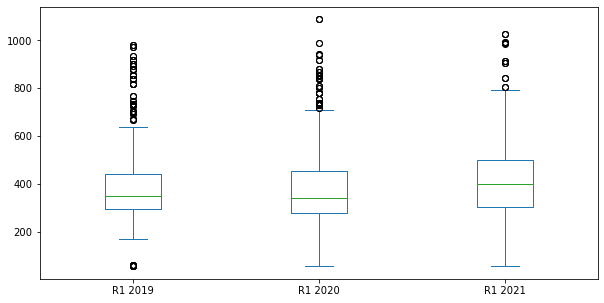

In [96]:
# Draw a boxlot of data for each year groupped by HEI
hist = allcourses[['R1 2019', 'R1 2020', 'R1 2021', 'HEI']].plot.box(figsize=(10, 5))
hist.figure.savefig('out/hist_all_by_year.png')
#hist = allcourses.boxplot(by='HEI')

array([[<AxesSubplot:xlabel='R1 2019', ylabel='R1 2019'>,
        <AxesSubplot:xlabel='R1 2020', ylabel='R1 2019'>,
        <AxesSubplot:xlabel='R1 2021', ylabel='R1 2019'>],
       [<AxesSubplot:xlabel='R1 2019', ylabel='R1 2020'>,
        <AxesSubplot:xlabel='R1 2020', ylabel='R1 2020'>,
        <AxesSubplot:xlabel='R1 2021', ylabel='R1 2020'>],
       [<AxesSubplot:xlabel='R1 2019', ylabel='R1 2021'>,
        <AxesSubplot:xlabel='R1 2020', ylabel='R1 2021'>,
        <AxesSubplot:xlabel='R1 2021', ylabel='R1 2021'>]], dtype=object)

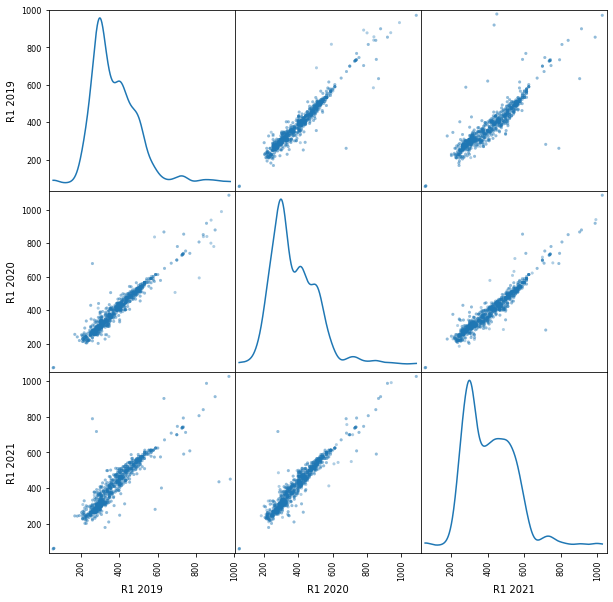

In [95]:
scatter_matrix(allcourses[['R1 2019', 'R1 2020', 'R1 2021']], alpha=0.2, figsize=(10, 10), diagonal="kde")

## References

# End
